In [1]:
import torch
import numpy as np
import math
from torch_geometric.data import Data,Dataset,DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from IPython.display import clear_output
from torch.nn import Linear,Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GENConv,CGConv,EdgePooling
from torch_geometric.nn import global_mean_pool,max_pool_neighbor_x,TopKPooling,global_max_pool
import sklearn
import copy
import pickle
import json



21984
[384, 3469] [5000, 5000]
(972, 28) 21984 740 232 740 232
[765, 6925] [10000, 10000]
(1930, 28) 21984 1462 468 1462 468
[1128, 10381] [15000, 15000]
(2847, 28) 21984 2154 693 2154 693
[1497, 13845] [20000, 20000]
(3705, 28) 21984 2808 897 2808 897
[1879, 17285] [25000, 25000]
(4585, 28) 21984 3466 1119 3466 1119
[2230, 20763] [30000, 30000]
(5456, 28) 21984 4144 1312 4144 1312
[2595, 24229] [35000, 35000]
(6376, 28) 21984 4833 1543 4833 1543
[2983, 27649] [40000, 40000]
(7281, 28) 21984 5499 1782 5499 1782
[3369, 31100] [45000, 45000]
(8200, 28) 21984 6182 2018 6182 2018
[3766, 34558] [50000, 50000]
(9103, 28) 21984 6846 2257 6846 2257
[4163, 38009] [55000, 55000]
(10021, 28) 21984 7534 2487 7534 2487
[4521, 41421] [60000, 60000]
(10955, 28) 21984 8248 2707 8248 2707
[4924, 44870] [65000, 65000]
(11902, 28) 21984 8948 2954 8948 2954
[5314, 48313] [70000, 70000]
(12818, 28) 21984 9630 3188 9630 3188
[5696, 51851] [75000, 75000]
(13727, 28) 21984 10322 3405 10322 3405
[6040, 55362] 

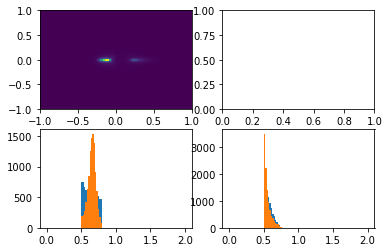

In [2]:

def principal_axis(partlist):
    tan_theta=0.0;
    M11=0.0;
    M20=0.0;
    M02=0.0;
    for i in range(len(partlist)):
        M11 += partlist[i].pt*partlist[i].phi*partlist[i].eta
        M20 += partlist[i].pt*partlist[i].phi*partlist[i].phi
        M02 += partlist[i].pt*partlist[i].eta*partlist[i].eta

    denom=(M20-M02+math.sqrt(4*M11*M11+(M20-M02)*(M20-M02)))
    if(denom!=0.0):
            tan_theta=2.0*M11/denom
    return tan_theta;


class part():
    def __init__(self,pt,eta,phi):
        self.pt=pt
        self.eta=eta
        self.phi=phi
def invm(p1,p2):
    return p1.pt*p2.pt*(math.cosh(p1.eta-p2.eta)-math.cos(p1.phi-p2.phi))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32

process=True
if process:
    
    """fin = open("QCDDTv1Full.dat", "rt")
    fout = open("QCDDTv1Full_mod.dat", "wt")
    for line in fin:
        fout.write(line.replace("inf", "0.0").replace("nan", "0.0"))
    fin.close()
    fout.close()

    fin = open("HbbDTv1Full.dat", "rt")
    fout = open("HbbDTv1Full_mod.dat", "wt")
    for line in fin:
        fout.write(line.replace("inf", "0.0").replace("nan", "0.0"))
    fin.close()
    fout.close()"""


    maxjets=5000

    sigfile = pd.read_json("HbbDTv1Full_mod.dat", lines=True,chunksize=maxjets)

    """for il,x2 in enumerate(sigfile):
        print (il)
        if (il>(51000/maxjets)):
            print (x2)"""
    bkgfile = pd.read_json("QCDDTv1Full_mod.dat", lines=True,chunksize=maxjets)

    """for il,x2 in enumerate(bkgfile):
        if (il==2193):
            print (x2)
        print (il)"""

    
    ntotjets=batch_size*int(22000/batch_size)
    print(ntotjets)
    nstot=0
    nbtot=0
    nstotinset=0
    nbtotinset=0
    sdone=False
    bdone=False
    nsel=[0,0]
    ntot=[0,0]
    for il,(x1,x2) in enumerate(zip(sigfile,bkgfile)):
        #print(0.4<x1.iloc[:,-2])
        x1filt = x1[0.5<x1.iloc[:,-2]]
        x1filt = x1filt[x1filt.iloc[:,-2]<0.8]
        x2filt = x2[0.5<x2.iloc[:,-2]]
        x2filt = x2filt[x2filt.iloc[:,-2]<0.8]
        
        ntot[0]+=x2.shape[0]
        ntot[1]+=x1.shape[0]
        nsel[0]+=x2filt.shape[0]
        nsel[1]+=x1filt.shape[0]
        
        x1filt = x1filt[x1filt.iloc[:,-1]>0.5]
        x1filt = x1filt[x1filt.iloc[:,-1]<0.75]        
        x2filt = x2filt[x2filt.iloc[:,-1]>0.5]
        x2filt = x2filt[x2filt.iloc[:,-1]<0.75]
        #[x2.iloc[:,-1]>0.5][x2.iloc[:,-1]<0.75]

        print (nsel,ntot)
        nstot+=x1filt.shape[0]
        nbtot+=x2filt.shape[0]
        #print (x1filt.iloc[0])

        if il==0:
            fullset=pd.concat((x1filt,x2filt))
            nstotinset+=nstot
            nbtotinset+=nbtot

        else:
            if nstot<=ntotjets/2:
                nstotinset+=x1filt.shape[0]
                fullset=pd.concat((fullset,x1filt))
                
            else:
                sdone=True
            if nbtot<=ntotjets/2:
                nbtotinset+=x2filt.shape[0]
                fullset=pd.concat((fullset,x2filt))
                
            else:
                bdone=True
        print(fullset.shape,ntotjets,nstot,nbtot,nstotinset,nbtotinset)
        if (bdone&sdone):
            break
    print (fullset.shape)

    totjets=(fullset.shape)[0]
    datas = []
    drarr=[]
    phiarr=[]
    etaarr=[]
    ptarr=[]
    jetptarr=[[],[]]
    jetmassarr=[[],[]]

    for ij,fullevt in enumerate(fullset.iloc):
        if ij%1000==0:
            print (ij,totjets)
        jetval = fullevt.iloc[0]
        #print (ij,fullevt.iloc[1])
        jetid = torch.tensor(int(abs(int(fullevt.iloc[1]))>4))

        #print(jetid)
        #jetone=F.one_hot(jetid, num_classes=2)
        #print (jetid,jetone)
        partlist=[]
        edgelist=[[],[]]
        edgelist1=[[],[]]
        edgelist2=[[],[]]
        edgelist3=[[],[]]
        edgelist4=[[],[]]

        edgefeat=[]
        posm=[]
        ptsum=0.0
        particles=[]
        for ip,partval in enumerate(jetval):
            #rands = torch.randn(3)
            curp=part(partval[0],partval[1],partval[2])
            #print (partval)
            particles.append(curp)
            #partlist.append([curp.pt,curp.eta,curp.phi,partval[3],partval[4],partval[5],partval[6]])
            partlist.append([curp.pt,curp.eta,curp.phi])

            #print(partval)




            #print (prunedfile[-1])
            ptsum+=curp.pt

            for jp,secval in enumerate(jetval):

                #if ip==jp:
                 #   continue

                #print (secval[0][9])
                secp=part(secval[0],secval[1],secval[2])

                DR=math.sqrt((curp.eta-secp.eta)**2+(curp.phi-secp.phi)**2)
                drarr.append(DR)

                if (DR<0.02):
                    #print (ip)
                    edgelist[0].append(int(ip))
                    edgelist[1].append(int(jp))

                    edgefeat.append([invm(curp,secp),curp.eta-secp.eta,curp.phi-secp.phi])
                    edgefeat.append([invm(curp,secp),curp.eta-secp.eta,curp.phi-secp.phi])
                if (0.02<DR<0.05):
                    #print (ip)
                    edgelist1[0].append(int(ip))
                    edgelist1[1].append(int(jp))

                if (0.05<DR<0.1):
                    #print (ip)
                    edgelist2[0].append(int(ip))
                    edgelist2[1].append(int(jp))
                    
                if (0.1<DR<0.2):
                    #print (ip)
                    edgelist3[0].append(int(ip))
                    edgelist3[1].append(int(jp))
                    
                if (0.2<DR<0.4):
                    #print (ip)
                    edgelist4[0].append(int(ip))
                    edgelist4[1].append(int(jp))
        tan_theta=principal_axis(particles)

        for ipt,curpart in enumerate(particles):
                Reta = curpart.phi*math.cos(math.atan(tan_theta))+curpart.eta*math.sin(math.atan(tan_theta));
                Rphi = -1.0*curpart.phi*math.sin(math.atan(tan_theta))+curpart.eta*math.cos(math.atan(tan_theta));
                partlist[ipt][1]=Reta
                partlist[ipt][2]=Rphi
                curpart.eta=Reta
                curpart.phi=Rphi


        lpt=0
        rpt=0
        for ipt,curpart in enumerate(particles):
                if curpart.eta>0:
                    lpt+=curpart.pt
                else:
                    rpt+=curpart.pt

        for ipt,curpart in enumerate(particles):  
                if lpt>rpt:
                    curpart.eta=-1*curpart.eta
                    


                #curpart.eta=max(min(curpart.eta/1.6+0.5,1.0),0.0)
                #curpart.phi=max(min(curpart.phi/1.6+0.5,1.0),0.0)
                partlist[ipt][2]=curpart.phi
                partlist[ipt][1]=curpart.eta
                posm.append([curpart.eta,curpart.phi])
                if jetid==1:
                    phiarr.append(curpart.phi)
                    etaarr.append(curpart.eta)
                    ptarr.append(curpart.pt)

        #print(fullevt)
        jetfloats=[]
        for ifl in range(2,25):
            #print (fullevt.iloc[ifl])
            jetfloats.append(fullevt.iloc[ifl])
        #print (fullevt.iloc[-3],fullevt.iloc[-2],fullevt.iloc[-1])
    
        jetfloats.append(fullevt.iloc[-2])
        jetptarr[jetid].append(fullevt.iloc[-1])
        jetmassarr[jetid].append(fullevt.iloc[-2])
        #print (len(edgelist[0]))
        #print (len(edgelist1[0]))
        #print (len(edgelist2[0]))
        #print (len(edgelist3[0]))
        #print (len(edgelist4[0]))
        datas.append(Data(x = torch.tensor(partlist, dtype=torch.float),pos=torch.tensor(posm, dtype=torch.float), edge_index1=torch.tensor(edgelist1, dtype=torch.long), edge_index2=torch.tensor(edgelist2, dtype=torch.long),edge_index3=torch.tensor(edgelist3, dtype=torch.long),edge_index4=torch.tensor(edgelist4, dtype=torch.long), edge_index=torch.tensor(edgelist, dtype=torch.long),y=jetid,jetfloats=torch.tensor([jetfloats], dtype=torch.float)).to(device))
        TM=0
        if ip%3==0:
            TM=1
        datas[-1].test_mask=TM
    
    #plt.hist(etaarr,bins=100,range=[[-1,1],[-1,1]] )
    
    fig, axs = plt.subplots(2,2)
    axs[0][0].hist2d(etaarr,phiarr,bins=100,range=[[-1,1],[-1,1]],weights=ptarr )
    axs[1][0].hist(jetmassarr[0],bins=100,range=[0,2] )
    axs[1][0].hist(jetmassarr[1],bins=100,range=[0,2] )
    axs[1][1].hist(jetptarr[0],bins=100,range=[0,2] )
    axs[1][1].hist(jetptarr[1],bins=100,range=[0,2] )


    with open('datas.pickle', 'wb') as handle:
        pickle.dump(datas, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('datas.pickle', 'rb') as handle:
        print ("Load Pickle")
        datas = pickle.load(handle)
print ("Make DataLoader")

dataloader=DataLoader(datas,batch_size=batch_size, shuffle=True)
print ("Done")

In [3]:

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    #acc = torch.round(acc * 100)

    return acc
"""def CApool(datax,curfeat):
    datax.pos.shape
    newx=[]
    newedge=[]
    newedgefeat=[]
    newpos=[]
    gindex=0
    for ibatch in range (max(datax.batch)):
        print(ibatch)
        dataxbpos = datax.pos[datax.batch==ibatch]
        dataxbx = datax.x[datax.batch==ibatch]

        curfeatpos = curfeat[datax.batch==ibatch]

        merged=[]
        for ip,partval in enumerate(dataxbpos):
            if ip in merged:
                continue
            #print (partval,dataxbpos)
            drs=(torch.sqrt((partval[0]-dataxbpos[:,0])**2+(partval[1]-dataxbpos[:,1])**2))
            drs[drs==0.0]=999999.0
            merged.append(torch.argmin(drs))
            newx.append([curfeatpos[ip]+curfeatpos[merged[-1]]])
            newpos.append([torch.mean(dataxbx[ip,0]*dataxbx[ip,1],dataxbx[merged[-1],0]*dataxbx[merged[-1],1]),torch.mean(dataxbx[ip,0]*dataxbx[ip,2],dataxbx[merged[-1],0]*dataxbx[merged[-1],2])])
            gindex+=1
            
        for ip,partval in enumerate(newpos):
            for jp,secval in enumerate(newpos):

    return datax
"""
def reedge(xinput,DRval):
    print (xinput.shape)
    edgelist1=torch.zeros((2,xinput))
    for i1 in range(xinput.shape[0]):
        DR=torch.sqrt((xinput[i1,0]-xinput[:,0])**2+(xinput[i1,1]-xinput[:,1])**2)
        #print (torch.where(DR<0.1))
        tw=torch.where(DR<DRval)
        edgelist1[0].append(tw)
        #print(tw)
        edgelist1[1].append(i1*(torch.ones_like(tw[0])))
    print(len(edgelist1))
    return torch.tensor(edgelist1, dtype=torch.long).to(device)
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GENConv(3, 2*hidden_channels,num_layers=2)
        self.edgepool1=EdgePooling(2*hidden_channels,add_to_edge_score=0)

        self.conv2 = GENConv(2*hidden_channels, 2*hidden_channels,num_layers=2)
        self.edgepool2=EdgePooling(2*hidden_channels,add_to_edge_score=0)

        self.conv3 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)
        self.edgepool3=EdgePooling(2*hidden_channels,add_to_edge_score=0)      

        self.conv4 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)        
        self.conv5 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)
 
        self.jflin =  Linear(23+1, 2*hidden_channels)
        self.convlin =  Linear(2*hidden_channels, 2*hidden_channels)

        self.lin0 =  Linear(4*hidden_channels, 2*hidden_channels)
        self.lin1 =  Linear(2*hidden_channels, hidden_channels)
        self.lin2 =  Linear(hidden_channels, 2)

    def forward(self, data):
        xinput, edge_index, edge_index1, edge_index2, edge_index3, edge_index4, batch, edge_attr, jetfloats =data.x, data.edge_index, data.edge_index1, data.edge_index2,data.edge_index3,data.edge_index4, data.batch, data.edge_attr, data.jetfloats
        
        #newedge = reedge(data.pos,0.05)
        x = self.conv1(xinput, edge_index)
        x = x.relu()

        #newedge = reedge(data.pos,0.1)        

        x = self.conv2(x, edge_index1)
        x = x.relu()

    
        x = self.conv3(x, edge_index2)
        x = x.relu()
 
        x = self.conv4(x, edge_index3)
        x = x.relu()
        
        x = self.conv5(x, edge_index4)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        x = self.convlin(x)
        x = x.relu()
        
        jetfloats=self.jflin(data.jetfloats)
        jetfloats=jetfloats.relu()
        jetfloats = F.dropout(jetfloats, p=0.5, training=self.training)
        
        x = torch.cat((x,jetfloats),dim=1)
        
        x = self.lin0(x)
        x = x.relu()


        x = self.lin1(x)
        x = x.relu()    
        x = F.dropout(x, p=0.5, training=self.training)
        

        x = F.log_softmax(self.lin2(x),dim=1)
        
        return x
    
    
    
    
    
    
    
    

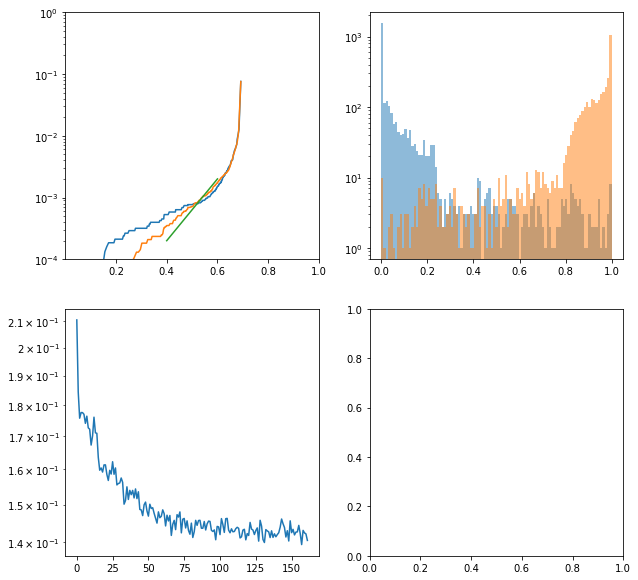

Adjusting learning rate of group 0 to 4.8828e-06.


KeyboardInterrupt: 

In [4]:

    
dataset=dataloader.dataset
model = GCN(hidden_channels=32).to(device)

#model = Net().to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = F.nll_loss

lrshed=torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.5, last_epoch=-1, verbose=True)

nep=2000
allloss=[]
allacc=[]

for ep in range(nep):
    lossarr=0.0
    accarr=0.0

    sigs=[[],[]]
    bkgs=[[],[]]
    for idata,data in enumerate(dataloader): 
             if (data.batch.max()+1!=batch_size):
                continue

             model.train()   
             alldat =  model(data)

             rando=torch.randn_like(data.x)*0.0
             #print(data.x+rando*data.x)
             data.x= data.x+rando*data.x
             traindat,traintrue = alldat[data.test_mask==0],(data.y)[data.test_mask==0]


             sigs[1].extend(traindat.exp()[traintrue==1].cpu().detach().numpy()[:,1])
             bkgs[1].extend(traindat.exp()[traintrue==0].cpu().detach().numpy()[:,1])
            
             loss = criterion(traindat, traintrue)
                
             optimizer.zero_grad()  
             loss.backward() 
             optimizer.step()  

            
             model.eval()  
             alldat =  model(data)

             testdat,testtrue = alldat[data.test_mask==1],(data.y)[data.test_mask==1]
             out = testdat.exp()
             #print (out)

             outmatch=out[testtrue>0.5][:,1]
             truematch=testtrue[testtrue>0.5]
             outmatch =torch.cat((outmatch,out[testtrue<0.5][:,0]))
             truematch=torch.cat((truematch,testtrue[testtrue<0.5]))
             #print (out.shape)
             #print (outmatch.shape)
           

             acc = binary_acc(outmatch, (truematch).to(device)) 
             #print (outmatch) 
             #print (truematch)
             sigs[0].extend(out[testtrue==1].cpu().detach().numpy()[:,1])
             bkgs[0].extend(out[testtrue==0].cpu().detach().numpy()[:,1])
             #print(sigs[0][-1],sigs[1][-1])
             #print(out.shape)
             #print(data.x)

             #print (data.x[out[data.y==0][:,1]>0.999])

             lossarr+=loss
             accarr+=acc
             #for zz in (zip(out, data.y)):
              #  print (zz)

    allloss.append((lossarr/idata).detach().cpu().numpy())
    allacc.append((accarr/idata).detach().cpu().numpy())

    bins = np.linspace(0, 1, 100)
    
    #summedtrue=[0]*len(bkgs)
    #summedtrue.extend([1]*len(sigs))
    #summedpred=copy.deepcopy(bkgs)
    #summedpred.extend(sigs)

    
    #rocby,rocbx,thresh=sklearn.metrics.roc_curve(summedtrue,summedpred, drop_intermediate=False)
    totb=[len(bkgs[0]),len(bkgs[1])]
    tots=[len(sigs[0]),len(sigs[1])]

    npoints=500
    bkgeff=[[],[]]
    sigeff=[[],[]]
    
    bkgmasseff=nsel[0]/ntot[0]
    sigmasseff=nsel[1]/ntot[1]
    
    print (totb,tots)
    #print (len(sigs))
    for ispl in range(2):
        for ith in range(npoints):
            thresh=float(ith/npoints)**(0.3)

            bkgeff[ispl].append(np.sum(np.array(bkgs[ispl])>thresh)/totb[ispl]*bkgmasseff)
            sigeff[ispl].append(np.sum(np.array(sigs[ispl])>thresh)/tots[ispl]*sigmasseff)
            #print (thresh)
            #print (bkgeff[ispl][-1], np.sum(np.array(bkgs[ispl])>thresh))
            #print (sigeff[ispl][-1], np.sum(np.array(sigs[ispl])>thresh))
            #print ()

    

    clear_output(wait=True)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    axs[0][0].plot(sigeff[0],bkgeff[0])
    axs[0][0].plot(sigeff[1],bkgeff[1])
    axs[0][0].plot([0.6,0.4],[0.002,0.0002])
    axs[0][0].plot([0.6],[0.01])
    axs[0][0].set_xlim([0.0001, 1])
    axs[0][0].set_ylim([0.0001, 1])
    axs[0][0].set_yscale("log")

    axs[0][1].hist(bkgs[0], bins, alpha=0.5, label='x')
    axs[0][1].hist(sigs[0], bins, alpha=0.5, label='y')
    axs[0][1].set_yscale("log")
    
    axs[1][0].plot(np.array(allloss))
    axs[1][0].set_yscale("log")
   #axs[1][1].plot(np.array(allacc))

    #print (sigeff)
    #print (bkgeff)


    plt.pause(0.0001)
    lrshed.step()